In [6]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
env = gym.make("CartPole-v1")
state = env.reset()
state
# position, velocity, angle, angular velocity

array([ 0.01174233, -0.02763735,  0.02245947, -0.04262478])

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from collections import deque
import random

In [4]:
model = Sequential()
model.add(Dense(units = 50, input_dim=4, activation='relu'))
model.add(Dense(units = 50, activation = "relu"))
model.add(Dense(units = 2, activation = "linear"))

In [9]:
#opt = keras.optimizers.Adam(learning_rate=0.001)#bad
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
#opt = keras.optimizers.SGD(learning_rate=0.001)

model.compile(loss='MSE',optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                250       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 2,902
Trainable params: 2,902
Non-trainable params: 0
_________________________________________________________________


Parametry:

In [10]:
train_episodes = 10
epsilon = 0.3
gamma = 0.99
max_steps = 200

Tworzymy **sieć docelową** (ang. target network):

In [11]:
target_model = tf.keras.models.clone_model(model)

Ustalamy jak często sieć ma być **synchronizowana**:

In [12]:
sync_freq = 30

Definiujemy **pamięć** jako kolejkę:

In [13]:
memory = deque(maxlen=100)

Ustalamy rozmiar **batch**:

In [14]:
batch_size = 10

Funkcja odpowiedzialna za **trenowanie modelu**:

In [15]:
def train():
  state_batch, Qs_target_batch = [], []
  
  minibatch = random.sample(memory, batch_size)
      
  for state, action, reward, next_state, done in minibatch:

    if done:
      y = reward
    else:
      #UWAGA!!!!
      #----------------------------------------------
      #wyliczając max Q korzystamy z 'target network' 
      y = reward + gamma*np.max(target_model.predict(next_state)[0])

    Q_target = model.predict(state)
    Q_target[0][action] = y
          
    state_batch.append(state)
    Qs_target_batch.append(Q_target)      
  
  state_batch = np.array(state_batch).reshape(batch_size,4)
  Qs_target_batch = np.array(Qs_target_batch).reshape(batch_size,2)

  h = model.fit(state_batch,Qs_target_batch,epochs=1,verbose=0)

  loss = h.history['loss'][0]

  return loss

In [19]:
Loss = []
Rewards = []

#zmienna do zliczania kroków w epizodach
j = 0
for e in range(1, train_episodes+1):
  total_reward = 0
  t = 0

  state = env.reset()
  state = np.reshape(state, [1, 4])  
  
  done = False
  while t < max_steps and done == False:
    #!!!!!
    j=j+1
    Qs = model.predict(state)[0]

    if np.random.rand()<epsilon:
      action = env.action_space.sample()
    else:
      action = np.argmax(Qs)
    
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, 4])
    
    total_reward += reward

    memory.append((state,action,reward,next_state,done))

    if batch_size < len(memory):
      loss = train()
      Loss.append(loss)

    state = next_state
    t+=1

    #synchronizacja 'target network'
    if j%sync_freq==0:
      #w = self.model.get_weights()
      w = model.get_weights()
      target_model.set_weights(w)
  
  print(e," R=",total_reward)
  Rewards.append(total_reward)

1  R= 9.0
2  R= 11.0
3  R= 10.0
4  R= 12.0
5  R= 9.0
6  R= 9.0
7  R= 16.0
8  R= 9.0
9  R= 10.0
10  R= 9.0


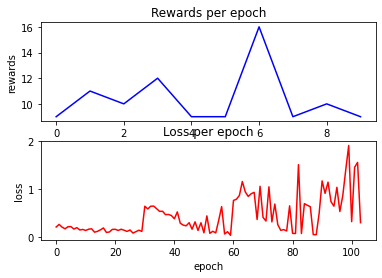

In [20]:
plt.subplot(211)
plt.ylabel('rewards')  
plt.title('Rewards per epoch')
plt.plot(range(len(Rewards)),Rewards,"b")

plt.subplot(212)
plt.xlabel('epoch')
plt.ylabel('loss')  
plt.title('Loss per epoch')
plt.plot(range(len(Loss)),Loss,"r")

plt.show()